# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "RF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'RF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups            
Sample_167  Q5KU26                       18.170
Sample_203  P21333;P21333-2;Q5HY54       14.979
Sample_024  C9JFR7;P99999                15.855
Sample_107  P07711                       18.211
Sample_052  A0A0A0MT32;P38571;P38571-2   15.331
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by RF: runs/alzheimer_study/preds/pred_real_na_RF.csv


Sample ID   protein groups                                     
Sample_175  A0A0G2JQ91;Q7Z304                                     13.829
Sample_156  A0A0C4DG76;Q5JZ08;Q9BQS7;Q9BQS7-2;Q9BQS7-3;Q9BQS7-4   16.253
Sample_025  C9J4G9;C9J539;P16278;P16278-3                         13.001
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.161
            A0A075B6Q5                 13.205
            A0A075B6R2                 12.032
            A0A075B6S5                 14.004
            A0A087WSY4                 12.606
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   11.961
            Q9UI40;Q9UI40-2            12.558
            Q9UIW2                     15.054
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.184
            Q9UP79                     12.548
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.918,15.050,16.842,19.863,15.657,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.336,19.067,...,15.528,15.576,13.900,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.614,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.868,17.705,17.039,16.294,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.981,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.110,15.345,17.084,18.708,14.249,19.433,12.467,11.217
Sample_207,15.739,16.877,15.469,16.898,15.228,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,13.382,11.593,13.756,12.599,11.802,11.598,12.712,13.964,12.386,13.240
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.289,19.067,16.127,...,14.428,13.107,12.230,12.333,13.617,12.949,11.943,13.357,13.253,11.832
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,11.956,12.895,12.912,13.132,12.856,13.450,12.630,12.719,14.869,11.738
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.307,13.082,13.012,12.300,13.171,13.055,13.291,12.830,12.430,14.844
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.586,13.325,13.213,12.103,13.745,14.669,13.191,12.590,13.771,13.987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.171,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 355.48it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  8.28it/s]

100%|██████████| 2/2 [00:00<00:00,  8.20it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.58it/s]

100%|██████████| 3/3 [00:00<00:00,  5.68it/s]

100%|██████████| 3/3 [00:00<00:00,  5.96it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.88it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.79it/s]

100%|██████████| 4/4 [00:00<00:00,  4.64it/s]

100%|██████████| 4/4 [00:00<00:00,  4.96it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.84it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.00it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.70it/s]

100%|██████████| 5/5 [00:01<00:00,  4.19it/s]

100%|██████████| 5/5 [00:01<00:00,  4.58it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  8.95it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.50it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.90it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.38it/s]

100%|██████████| 6/6 [00:01<00:00,  4.12it/s]

100%|██████████| 6/6 [00:01<00:00,  4.64it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.12it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.41it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.89it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.46it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.14it/s]

100%|██████████| 7/7 [00:01<00:00,  4.14it/s]

100%|██████████| 7/7 [00:01<00:00,  4.53it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.58it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.72it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.34it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.53it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.37it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.21it/s]

100%|██████████| 8/8 [00:01<00:00,  4.23it/s]

100%|██████████| 8/8 [00:01<00:00,  4.45it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  9.75it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.47it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.76it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.19it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.07it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.99it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.89it/s]

100%|██████████| 9/9 [00:02<00:00,  4.16it/s]

100%|██████████| 9/9 [00:02<00:00,  4.40it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.36it/s]

 30%|███       | 3/10 [00:00<00:01,  4.61it/s]

 40%|████      | 4/10 [00:00<00:01,  4.13it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.98it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.74it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.58it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.65it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.84it/s]

100%|██████████| 10/10 [00:02<00:00,  3.92it/s]

100%|██████████| 10/10 [00:02<00:00,  3.99it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00,  9.34it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.91it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.09it/s]

 45%|████▌     | 5/11 [00:00<00:01,  4.85it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.81it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.55it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.22it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  4.36it/s]

 91%|█████████ | 10/11 [00:02<00:00,  4.49it/s]

100%|██████████| 11/11 [00:02<00:00,  4.39it/s]

100%|██████████| 11/11 [00:02<00:00,  4.72it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.84it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.58it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.71it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.27it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.07it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.97it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.92it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.91it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.72it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.81it/s]

100%|██████████| 12/12 [00:02<00:00,  3.99it/s]

100%|██████████| 12/12 [00:02<00:00,  4.17it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.42it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.28it/s]

 31%|███       | 4/13 [00:00<00:01,  4.64it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.43it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.21it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.03it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  3.36it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.09it/s]

 77%|███████▋  | 10/13 [00:02<00:01,  2.95it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.90it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.88it/s]

100%|██████████| 13/13 [00:03<00:00,  2.93it/s]

100%|██████████| 13/13 [00:03<00:00,  3.44it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.72it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.83it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.63it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.04it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.84it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.67it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.64it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.77it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.84it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.16it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.29it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  3.53it/s]

100%|██████████| 14/14 [00:04<00:00,  3.55it/s]

100%|██████████| 14/14 [00:04<00:00,  3.26it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  8.55it/s]

 20%|██        | 3/15 [00:00<00:02,  5.68it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.63it/s]

 33%|███▎      | 5/15 [00:01<00:02,  4.36it/s]

 40%|████      | 6/15 [00:01<00:02,  4.00it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.73it/s]

 53%|█████▎    | 8/15 [00:01<00:02,  3.35it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.43it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.59it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.20it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.22it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.05it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  2.86it/s]

100%|██████████| 15/15 [00:04<00:00,  2.64it/s]

100%|██████████| 15/15 [00:04<00:00,  3.39it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.004      0.039 0.012          0.723 0.383       0.103   
2             0.004 0.002      0.036 0.006          0.619 0.135       0.461   
3             0.003 0.000      0.037 0.008          0.814 0.087       0.717   
4             0.004 0.003      0.038 0.010          0.809 0.084       0.766   
5             0.005 0.003      0.046 0.017          0.834 0.084       0.786   
6             0.003 0.000      0.040 0.013          0.837 0.087       0.784   
7             0.005 0.004      0.048 0.020          0.830 0.091       0.776   
8             0.005 0.004      0.043 0.014          0.822 0.083       0.834   
9             0.005 0.004      0.041 0.014          0.824 0.085       0.830   
10            0.004 0.003      0.040 0.015          0.815 0.082       0.824   
11            0.003 0.000      0.037 0.013          0.825 0.078       0.826   
12            0.004 0.002      0.037 0.009          0.826 0.077       0.822   
13            0.006 0.005      0.052 0.018          0.829 0.084       0.796   
14            0.005 0.003      0.044 0.016          0.828 0.082       0.792   
15            0.004 0.001      0.038 0.007          0.826 0.083       0.785   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.083   0.173 0.128                  0.544 0.040        0.859   
2          0.118   0.517 0.098                  0.621 0.066        0.701   
3          0.103   0.758 0.077                  0.798 0.061        0.903   
4          0.106   0.782 0.072                  0.815 0.059        0.908   
5          0.102   0.805 0.070                  0.834 0.058        0.915   
6          0.103   0.804 0.070                  0.834 0.059        0.913   
7          0.111   0.796 0.074                  0.827 0.061        0.912   
8          0.103   0.824 0.072                  0.850 0.061        0.923   
9          0.107   0.822 0.074                  0.849 0.063        0.920   
10         0.109   0.815 0.071                  0.842 0.060        0.919   
11         0.105   0.822 0.070                  0.848 0.060        0.920   
12         0.108   0.819 0.069                  0.846 0.059        0.920   
13         0.106   0.807 0.074                  0.837 0.061        0.921   
14         0.102   0.804 0.070                  0.834 0.057        0.919   
15         0.098   0.800 0.067                  0.830 0.055        0.919   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.828 0.089        210.000 0.000  
2          0.082                  0.648 0.098        210.000 0.000  
3          0.049                  0.880 0.062        210.000 0.000  
4          0.048                  0.885 0.057        210.000 0.000  
5          0.050                  0.896 0.061        210.000 0.000  
6          0.051                  0.895 0.061        210.000 0.000  
7          0.054                  0.894 0.063        210.000 0.000  
8          0.046                  0.912 0.050        210.000 0.000  
9          0.049                  0.907 0.054        210.000 0.000  
10         0.048                  0.908 0.049        210.000 0.000  
11         0.047                  0.911 0.049        210.000 0.000  
12         0.047                  0.910 0.049        210.000 0.000  
13         0.049                  0.913 0.049        210.000 0.000  
14         0.048                  0.911 0.049        210.000 0.000  
15         0.047                  0.910 0.048 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 491.19it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.41it/s]

100%|██████████| 2/2 [00:00<00:00,  7.35it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.55it/s]

100%|██████████| 3/3 [00:00<00:00,  4.18it/s]

100%|██████████| 3/3 [00:00<00:00,  4.38it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.08it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.54it/s]

100%|██████████| 4/4 [00:01<00:00,  3.30it/s]

100%|██████████| 4/4 [00:01<00:00,  3.52it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.22it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.26it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.11it/s]

100%|██████████| 5/5 [00:01<00:00,  3.06it/s]

100%|██████████| 5/5 [00:01<00:00,  3.20it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.03it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.59it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.06it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.05it/s]

100%|██████████| 6/6 [00:01<00:00,  3.16it/s]

100%|██████████| 6/6 [00:01<00:00,  3.24it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.13it/s]

 43%|████▎     | 3/7 [00:00<00:01,  2.92it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.60it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.45it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.63it/s]

100%|██████████| 7/7 [00:02<00:00,  2.70it/s]

100%|██████████| 7/7 [00:02<00:00,  2.74it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.88it/s]

 38%|███▊      | 3/8 [00:01<00:01,  2.64it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.33it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  2.22it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.24it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.39it/s]

100%|██████████| 8/8 [00:03<00:00,  2.47it/s]

100%|██████████| 8/8 [00:03<00:00,  2.46it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  3.61it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.46it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.26it/s]

 56%|█████▌    | 5/9 [00:02<00:01,  2.15it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.16it/s]

 78%|███████▊  | 7/9 [00:03<00:00,  2.22it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.32it/s]

100%|██████████| 9/9 [00:03<00:00,  2.43it/s]

100%|██████████| 9/9 [00:03<00:00,  2.37it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.53it/s]

 30%|███       | 3/10 [00:00<00:01,  4.66it/s]

 40%|████      | 4/10 [00:01<00:01,  3.28it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.71it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.40it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.26it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.23it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.33it/s]

100%|██████████| 10/10 [00:03<00:00,  2.56it/s]

100%|██████████| 10/10 [00:03<00:00,  2.69it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.44it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.88it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.28it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.80it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.45it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.32it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.16it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.29it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.43it/s]

100%|██████████| 11/11 [00:04<00:00,  2.53it/s]

100%|██████████| 11/11 [00:04<00:00,  2.67it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.65it/s]

 25%|██▌       | 3/12 [00:00<00:01,  4.74it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.36it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.68it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.03it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.74it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.42it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.30it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.29it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.25it/s]

100%|██████████| 12/12 [00:04<00:00,  2.29it/s]

100%|██████████| 12/12 [00:04<00:00,  2.72it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.70it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.18it/s]

 31%|███       | 4/13 [00:00<00:02,  4.20it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.33it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.91it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.86it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.75it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.73it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.70it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.55it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.48it/s]

100%|██████████| 13/13 [00:04<00:00,  2.38it/s]

100%|██████████| 13/13 [00:04<00:00,  2.86it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.86it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.78it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.06it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.74it/s]

 43%|████▎     | 6/14 [00:02<00:02,  2.69it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.58it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.55it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.68it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.72it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.75it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.90it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.96it/s]

100%|██████████| 14/14 [00:04<00:00,  2.94it/s]

100%|██████████| 14/14 [00:04<00:00,  2.89it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.82it/s]

 20%|██        | 3/15 [00:00<00:03,  3.43it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.94it/s]

 33%|███▎      | 5/15 [00:01<00:04,  2.38it/s]

 40%|████      | 6/15 [00:02<00:03,  2.39it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.38it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.32it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.22it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.34it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.46it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.48it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.54it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.71it/s]

100%|██████████| 15/15 [00:05<00:00,  2.81it/s]

100%|██████████| 15/15 [00:05<00:00,  2.61it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.045 0.016          0.000 0.000       0.000   
2             0.004 0.004      0.045 0.014          0.679 0.144       0.321   
3             0.004 0.003      0.045 0.018          0.736 0.096       0.551   
4             0.005 0.004      0.050 0.018          0.730 0.096       0.552   
5             0.004 0.002      0.039 0.009          0.729 0.113       0.578   
6             0.004 0.000      0.039 0.011          0.700 0.088       0.611   
7             0.003 0.002      0.034 0.019          0.833 0.091       0.777   
8             0.004 0.003      0.044 0.016          0.826 0.089       0.773   
9             0.004 0.003      0.042 0.019          0.822 0.089       0.770   
10            0.007 0.006      0.050 0.023          0.849 0.088       0.777   
11            0.005 0.004      0.049 0.017          0.846 0.090       0.783   
12            0.005 0.003      0.052 0.023          0.847 0.088       0.781   
13            0.006 0.004      0.053 0.021          0.846 0.091       0.778   
14            0.006 0.005      0.060 0.027          0.829 0.087       0.771   
15            0.005 0.003      0.048 0.019          0.838 0.091       0.794   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.497 0.008        0.853   
2          0.104   0.423 0.100                  0.599 0.052        0.682   
3          0.106   0.623 0.084                  0.702 0.056        0.755   
4          0.105   0.623 0.083                  0.700 0.057        0.748   
5          0.098   0.639 0.086                  0.708 0.065        0.780   
6          0.107   0.647 0.080                  0.709 0.059        0.787   
7          0.105   0.799 0.077                  0.830 0.064        0.899   
8          0.111   0.794 0.081                  0.826 0.066        0.897   
9          0.113   0.790 0.081                  0.823 0.066        0.897   
10         0.098   0.807 0.073                  0.837 0.059        0.914   
11         0.100   0.808 0.073                  0.838 0.059        0.915   
12         0.098   0.808 0.073                  0.837 0.059        0.913   
13         0.098   0.806 0.075                  0.836 0.061        0.912   
14         0.107   0.794 0.074                  0.826 0.061        0.920   
15         0.105   0.809 0.074                  0.838 0.060        0.921   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.826 0.086        210.000 0.000  
2          0.091                  0.615 0.100        210.000 0.000  
3          0.075                  0.741 0.081        210.000 0.000  
4          0.073                  0.735 0.077        210.000 0.000  
5          0.070                  0.750 0.084        210.000 0.000  
6          0.069                  0.754 0.086        210.000 0.000  
7          0.053                  0.885 0.060        210.000 0.000  
8          0.054                  0.882 0.061        210.000 0.000  
9          0.055                  0.886 0.061        210.000 0.000  
10         0.047                  0.897 0.056        210.000 0.000  
11         0.047                  0.899 0.056        210.000 0.000  
12         0.048                  0.897 0.057        210.000 0.000  
13         0.048                  0.896 0.057        210.000 0.000  
14         0.044                  0.904 0.050        210.000 0.000  
15         0.043                  0.905 0.048 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1007.28it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 30.54it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 23.12it/s]

100%|██████████| 3/3 [00:00<00:00, 22.77it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 22.08it/s]

100%|██████████| 4/4 [00:00<00:00, 20.33it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 19.45it/s]

100%|██████████| 5/5 [00:00<00:00, 16.75it/s]

100%|██████████| 5/5 [00:00<00:00, 17.13it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 32.05it/s]

100%|██████████| 6/6 [00:00<00:00, 24.37it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 25.87it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 16.73it/s]

100%|██████████| 7/7 [00:00<00:00, 17.09it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 19.75it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 14.15it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 12.71it/s]

100%|██████████| 8/8 [00:00<00:00, 13.19it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 20.70it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 15.01it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 15.80it/s]

100%|██████████| 9/9 [00:00<00:00, 14.60it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 19.76it/s]

 50%|█████     | 5/10 [00:00<00:00, 13.67it/s]

 70%|███████   | 7/10 [00:00<00:00, 12.39it/s]

 90%|█████████ | 9/10 [00:00<00:00, 11.67it/s]

100%|██████████| 10/10 [00:00<00:00, 12.24it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 19.67it/s]

 45%|████▌     | 5/11 [00:00<00:00, 16.64it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 12.72it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 12.87it/s]

100%|██████████| 11/11 [00:00<00:00, 13.00it/s]

100%|██████████| 11/11 [00:00<00:00, 13.61it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 16.51it/s]

 42%|████▏     | 5/12 [00:00<00:00, 15.67it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 12.90it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 13.59it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 10.62it/s]

100%|██████████| 12/12 [00:00<00:00, 12.12it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 20.26it/s]

 46%|████▌     | 6/13 [00:00<00:00, 14.80it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 13.86it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 13.53it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 12.16it/s]

100%|██████████| 13/13 [00:01<00:00, 12.91it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 22.41it/s]

 43%|████▎     | 6/14 [00:00<00:00, 16.67it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 15.24it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 14.89it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 15.12it/s]

100%|██████████| 14/14 [00:00<00:00, 14.06it/s]

100%|██████████| 14/14 [00:00<00:00, 14.84it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 23.96it/s]

 40%|████      | 6/15 [00:00<00:00, 16.42it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 15.92it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 15.29it/s]

 80%|████████  | 12/15 [00:00<00:00, 14.89it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 14.75it/s]

100%|██████████| 15/15 [00:00<00:00, 15.20it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.043 0.015          0.000 0.000       0.000   
2             0.005 0.004      0.049 0.022          0.648 0.163       0.316   
3             0.003 0.002      0.038 0.014          0.658 0.161       0.316   
4             0.005 0.005      0.056 0.026          0.657 0.159       0.356   
5             0.004 0.002      0.039 0.013          0.686 0.155       0.359   
6             0.006 0.005      0.052 0.022          0.693 0.159       0.359   
7             0.004 0.002      0.050 0.018          0.633 0.144       0.340   
8             0.006 0.006      0.070 0.034          0.648 0.115       0.551   
9             0.007 0.006      0.060 0.020          0.648 0.115       0.559   
10            0.006 0.005      0.055 0.023          0.674 0.115       0.597   
11            0.006 0.005      0.057 0.026          0.680 0.101       0.587   
12            0.005 0.004      0.042 0.012          0.693 0.107       0.608   
13            0.005 0.004      0.058 0.024          0.691 0.104       0.606   
14            0.005 0.005      0.058 0.030          0.688 0.106       0.606   
15            0.008 0.007      0.066 0.020          0.678 0.102       0.598   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.729   
2          0.104   0.416 0.114                  0.592 0.064        0.677   
3          0.091   0.418 0.099                  0.592 0.058        0.669   
4          0.095   0.455 0.103                  0.606 0.068        0.655   
5          0.093   0.464 0.097                  0.615 0.061        0.654   
6          0.092   0.465 0.097                  0.616 0.060        0.646   
7          0.080   0.435 0.085                  0.593 0.055        0.653   
8          0.126   0.585 0.099                  0.662 0.068        0.749   
9          0.120   0.591 0.095                  0.665 0.068        0.746   
10         0.128   0.624 0.101                  0.690 0.071        0.743   
11         0.108   0.622 0.083                  0.689 0.058        0.768   
12         0.106   0.639 0.076                  0.701 0.059        0.772   
13         0.100   0.638 0.072                  0.699 0.056        0.768   
14         0.095   0.637 0.072                  0.697 0.058        0.766   
15         0.101   0.628 0.072                  0.691 0.057        0.763   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.070                  0.700 0.075        210.000 0.000  
2          0.084                  0.637 0.091        210.000 0.000  
3          0.083                  0.631 0.092        210.000 0.000  
4          0.090                  0.632 0.098        210.000 0.000  
5          0.085                  0.621 0.094        210.000 0.000  
6          0.085                  0.614 0.091        210.000 0.000  
7          0.077                  0.604 0.088        210.000 0.000  
8          0.073                  0.715 0.083        210.000 0.000  
9          0.073                  0.712 0.083        210.000 0.000  
10         0.077                  0.706 0.089        210.000 0.000  
11         0.071                  0.728 0.085        210.000 0.000  
12         0.073                  0.740 0.079        210.000 0.000  
13         0.074                  0.732 0.085        210.000 0.000  
14         0.075                  0.731 0.084        210.000 0.000  
15         0.075                  0.727 0.085 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,13,10,15
score_time,13,14,8
test_precision,6,10,12
test_recall,8,15,12
test_f1,8,15,12
test_balanced_accuracy,8,15,12
test_roc_auc,8,15,12
test_average_precision,13,15,12
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.20it/s]

 20%|██        | 3/15 [00:00<00:03,  3.62it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.60it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.48it/s]

 40%|████      | 6/15 [00:01<00:02,  3.34it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.32it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.05it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.64it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.38it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.22it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.09it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.18it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.16it/s]

100%|██████████| 15/15 [00:05<00:00,  2.08it/s]

100%|██████████| 15/15 [00:05<00:00,  2.56it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 19.77it/s]

 42%|████▏     | 5/12 [00:00<00:00, 14.62it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 14.07it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 13.89it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 12.33it/s]

100%|██████████| 12/12 [00:00<00:00, 13.73it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.22it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.86it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.22it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.40it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.31it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  3.09it/s]

100%|██████████| 8/8 [00:02<00:00,  2.81it/s]

100%|██████████| 8/8 [00:02<00:00,  3.19it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf


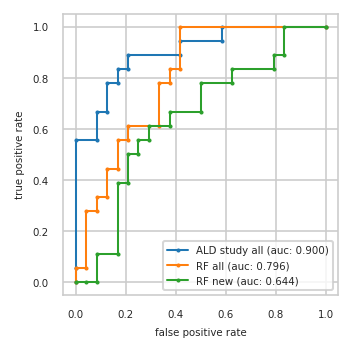

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       RF all       RF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.042 0.000
2          0.000 0.556  0.042 0.056  0.083 0.000
3          0.083 0.556  0.042 0.278  0.083 0.111
4          0.083 0.667  0.083 0.278  0.167 0.111
5          0.125 0.667  0.083 0.333  0.167 0.389
6          0.125 0.778  0.125 0.333  0.208 0.389
7          0.167 0.778  0.125 0.444  0.208 0.500
8          0.167 0.833  0.167 0.444  0.250 0.500
9          0.208 0.833  0.167 0.556  0.250 0.556
10         0.208 0.889  0.208 0.556  0.292 0.556
11         0.417 0.889  0.208 0.611  0.292 0.611
12         0.417 0.944  0.333 0.611  0.375 0.611
13         0.583 0.944  0.333 0.778  0.375 0.667
14         0.583 1.000  0.375 0.778  0.500 0.667
15         1.000 1.000  0.375 0.833  0.500 0.778
16           NaN   NaN  0.417 0.833  0.625 0.778
17           NaN   NaN  0.417 1.000  0.625 0.833
18           NaN   NaN  1.000 1.000  0.792 0.833
19           NaN   NaN    NaN   NaN  0.792 0.889
20           NaN   NaN    NaN   NaN  0.833 0.889
21           NaN   NaN    NaN   NaN  0.833 1.000
22           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,RF all,RF new
rank,,,
0,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,Q14894
1,P31946;P31946-2,Q9HAT2,P36269;P36269-2;P36269-3
2,Q9BRA2,A6XMH3;P01236;Q5I0G2,P10745
3,Q9UM22,P10636-2;P10636-6,Q96GD0
4,P61981,P14174,Q9NUQ9
5,C9JF17;P05090,Q14894,P31321
6,P04075,P61981,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
7,P14174,P04075,J3KSJ8;Q9UD71;Q9UD71-2
8,None,P25189;P25189-2,A0A075B7B8


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf


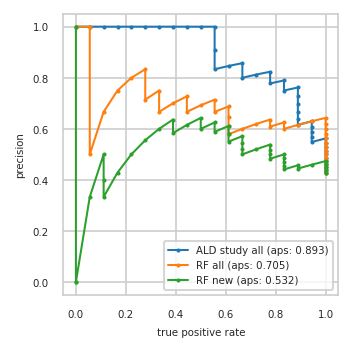

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          RF all          RF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.444 0.889
7          0.514 1.000     0.514 1.000     0.457 0.889
8          0.529 1.000     0.529 1.000     0.441 0.833
9          0.545 1.000     0.545 1.000     0.455 0.833
10         0.562 1.000     0.562 1.000     0.469 0.833
11         0.548 0.944     0.581 1.000     0.484 0.833
12         0.567 0.944     0.600 1.000     0.500 0.833
13         0.586 0.944     0.621 1.000     0.483 0.778
14         0.607 0.944     0.643 1.000     0.500 0.778
15         0.630 0.944     0.630 0.944     0.519 0.778
16         0.615 0.889     0.615 0.889     0.538 0.778
17         0.640 0.889     0.600 0.833     0.520 0.722
18         0.667 0.889     0.625 0.833     0.500 0.667
19         0.696 0.889     0.609 0.778     0.522 0.667
20         0.727 0.889     0.636 0.778     0.545 0.667
21         0.762 0.889     0.619 0.722     0.571 0.667
22         0.750 0.833     0.600 0.667     0.550 0.611
23         0.789 0.833     0.579 0.611     0.579 0.611
24         0.778 0.778     0.611 0.611     0.611 0.611
25         0.824 0.778     0.647 0.611     0.588 0.556
26         0.812 0.722     0.688 0.611     0.625 0.556
27         0.800 0.667     0.667 0.556     0.600 0.500
28         0.857 0.667     0.714 0.556     0.643 0.500
29         0.846 0.611     0.692 0.500     0.615 0.444
30         0.833 0.556     0.667 0.444     0.583 0.389
31         0.909 0.556     0.727 0.444     0.636 0.389
32         1.000 0.556     0.700 0.389     0.600 0.333
33         1.000 0.500     0.667 0.333     0.556 0.278
34         1.000 0.444     0.750 0.333     0.500 0.222
35         1.000 0.389     0.714 0.278     0.429 0.167
36         1.000 0.333     0.833 0.278     0.333 0.111
37         1.000 0.278     0.800 0.222     0.400 0.111
38         1.000 0.222     0.750 0.167     0.500 0.111
39         1.000 0.167     0.667 0.111     0.333 0.056
40         1.000 0.111     0.500 0.056     0.000 0.000
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf


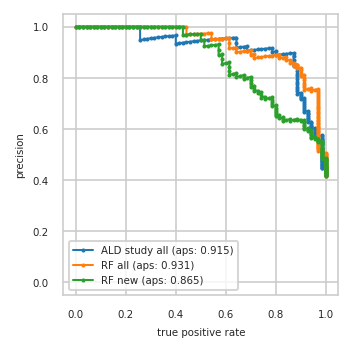

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf


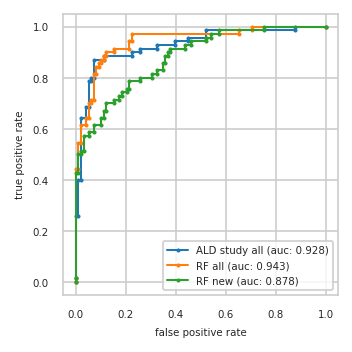

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_RF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF all.pkl'),
 'results_RF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf')}